# Predictive Modeling - NYC School Performance 🤖

**Goal:** Build ML models to predict SAT scores from school characteristics  
**Dataset:** Features extracted from demographics analysis  
**Created:** October 6, 2025

## What We'll Build
1. Baseline model (simple average)
2. Linear Regression
3. Random Forest (with feature importance)
4. Gradient Boosting (best performance)
5. Model comparison and evaluation
6. Feature importance analysis
7. Predictions on real schools

In [ ]:
# Setup
import sys
from pathlib import Path

project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.append(str(project_root))

# First, install scikit-learn if needed
try:
    import sklearn
    print("✅ scikit-learn already installed")
except ImportError:
    print("📦 Installing scikit-learn...")
    %pip install scikit-learn
    print("✅ scikit-learn installed!")

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ML libraries
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

from scripts.utils import load_csv, save_csv

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')

print("✅ All libraries loaded!")
print(f"📁 Project root: {project_root}")

📦 Installing scikit-learn...
  Using cached scikit_learn-1.7.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp311-cp311-win_amd64.whl (8.9 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.
✅ scikit-learn installed!



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ All libraries loaded!
📁 Project root: c:\git\dbt


## 1. Load Data

In [2]:
# Check if ML features dataset exists (created by demographics notebook)
try:
    ml_data = load_csv("ml_features_dataset.csv", subfolder="processed")
    print("✅ Loaded ML features dataset from demographics exploration")
except Exception as e:
    print(f"⚠️  ML features not found: {e}")
    print("Creating from raw data...")
    # Load raw data and create features
    sat = load_csv("zt9s-n5aj_20251006_114228.csv")
    demo = load_csv("s3k6-pzi2_20251006_114239.csv")
    
    # Convert SAT scores
    for col in ['mathematics_mean', 'critical_reading_mean', 'writing_mean', 'number_of_test_takers']:
        sat[col] = pd.to_numeric(sat[col], errors='coerce')
    sat['total_score'] = sat['mathematics_mean'] + sat['critical_reading_mean'] + sat['writing_mean']
    
    # Merge
    ml_data = sat.merge(demo, on='dbn', how='inner', suffixes=('_sat', '_demo'))
    print(f"✅ Created from raw data")

print(f"\n📊 Dataset shape: {ml_data.shape}")
print(f"   Schools: {len(ml_data)}")
print(f"   Columns: {len(ml_data.columns)}")
ml_data.head()

✅ Loaded ML features dataset from demographics exploration

📊 Dataset shape: (294, 43)
   Schools: 294
   Columns: 43


,dbn,school_name_sat,total_score,grade9swdapplicants8,grade9geapplicantsperseat8,grade9swdapplicantsperseat8,grade9geapplicants8,college_career_rate,grade9geapplicants1,grade9geapplicantsperseat3,grade9geapplicantsperseat7,graduation_rate,grade9geapplicants3,grade9swdapplicantsperseat5,grade9geapplicantsperseat6,attendance_rate,grade9geapplicantsperseat1,grade9swdapplicantsperseat6,grade9geapplicantsperseat5,grade9geapplicantsperseat2,grade9geapplicants2,applicants1specialized,grade9geapplicantsperseat4,grade9swdapplicants4,grade9swdapplicantsperseat1,seats9ge4,census_tract,seats9ge6,bin,bbl,seats9swd6,community_board,council_district,seats9swd4,zip,longitude,latitude,appperseat1specialized,seats9swd7,seats9ge7,grade9swdapplicants7,seats9swd8,seats9ge8
0,01M292,Henry Street School for International Studies,1201.0,NaN,NaN,NaN,NaN,0.262,112.0,NaN,NaN,0.639,NaN,NaN,NaN,0.77,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,201.0,NaN,1003223.0,1.002690e+09,NaN,3.0,1.0,NaN,10002,-73.9861,40.71336,NaN,NaN,NaN,NaN,NaN,NaN
1,01M448,University Neighborhood High School,1200.0,NaN,NaN,NaN,NaN,0.662,549.0,5.0,NaN,0.843,114.0,NaN,NaN,0.88,8.0,NaN,NaN,1.0,25.0,NaN,NaN,NaN,7.0,NaN,202.0,NaN,1003214.0,1.002590e+09,NaN,3.0,1.0,NaN,10002,-73.9841,40.71227,NaN,NaN,NaN,NaN,NaN,NaN
2,01M450,East Side Community High School,1251.0,NaN,NaN,NaN,NaN,0.722,1493.0,NaN,NaN,0.864,NaN,NaN,NaN,0.94,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,34.0,NaN,1005974.0,1.004390e+09,NaN,3.0,2.0,NaN,10009,-73.9825,40.72915,NaN,NaN,NaN,NaN,NaN,NaN
3,01M539,"New Explorations into Sci, Tech and Math HS",1719.0,NaN,NaN,NaN,NaN,0.823,3002.0,NaN,NaN,0.975,NaN,NaN,NaN,0.95,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,2201.0,NaN,1004070.0,1.003350e+09,NaN,3.0,2.0,NaN,10002,-73.9796,40.71942,NaN,NaN,NaN,NaN,NaN,NaN
4,01M696,BARD HIGH SCHOOL EARLY COLLEGE,1868.0,NaN,NaN,NaN,NaN,0.958,4046.0,NaN,NaN,0.974,NaN,NaN,NaN,0.96,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1002.0,NaN,1004062.0,1.003250e+09,NaN,3.0,2.0,NaN,10002,-73.9761,40.71828,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Prepare Features for ML

In [3]:
# Select only numeric columns for modeling
numeric_cols = ml_data.select_dtypes(include=[np.number]).columns.tolist()

# Remove target and ID columns
exclude_cols = ['total_score', 'mathematics_mean', 'critical_reading_mean', 'writing_mean', 'number_of_test_takers']
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"🎯 Target: total_score")
print(f"🔢 Available features: {len(feature_cols)}")

# Create feature matrix and target
X = ml_data[feature_cols].copy()
y = ml_data['total_score'].copy()

# Remove rows with missing target
mask = y.notna()
X = X[mask]
y = y[mask]

print(f"\n📊 After removing missing targets:")
print(f"   Samples: {len(X)}")
print(f"   Features: {len(X.columns)}")

# Check for missing values in features
missing_pct = (X.isnull().sum() / len(X) * 100).sort_values(ascending=False)
high_missing = missing_pct[missing_pct > 50]

if len(high_missing) > 0:
    print(f"\n⚠️  Removing {len(high_missing)} features with >50% missing data")
    X = X.drop(columns=high_missing.index)

# Fill remaining missing values with median
X = X.fillna(X.median())

print(f"\n✅ Final feature set: {len(X.columns)} features")
print(f"   Shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"   Target mean: {y.mean():.0f}")
print(f"   Target range: {y.min():.0f} - {y.max():.0f}")

🎯 Target: total_score
🔢 Available features: 40

📊 After removing missing targets:
   Samples: 294
   Features: 40

⚠️  Removing 26 features with >50% missing data

✅ Final feature set: 14 features
   Shape: (294, 14)
   Target shape: (294,)
   Target mean: 1241
   Target range: 915 - 2087


## 3. Train/Test Split

In [4]:
# Split data 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"📊 Data Split:")
print(f"   Training: {len(X_train)} schools ({len(X_train)/len(X)*100:.0f}%)")
print(f"   Testing: {len(X_test)} schools ({len(X_test)/len(X)*100:.0f}%)")

print(f"\n🎯 Target Distribution:")
print(f"   Train - Mean: {y_train.mean():.0f}, Std: {y_train.std():.0f}")
print(f"   Test  - Mean: {y_test.mean():.0f}, Std: {y_test.std():.0f}")

# Scale features (important for Linear Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Features scaled using StandardScaler")

📊 Data Split:
   Training: 235 schools (80%)
   Testing: 59 schools (20%)

🎯 Target Distribution:
   Train - Mean: 1246, Std: 193
   Test  - Mean: 1219, Std: 170

✅ Features scaled using StandardScaler


## 4. Baseline Model (Mean Predictor)

In [5]:
# Baseline: Always predict the mean
baseline_pred = np.full(len(y_test), y_train.mean())

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)

print("📊 BASELINE MODEL (Mean Predictor)")
print("="*60)
print(f"Mean Absolute Error:  {baseline_mae:.0f} points")
print(f"Root Mean Squared Error: {baseline_rmse:.0f} points")
print(f"R² Score: {baseline_r2:.3f}")
print("\n💡 This is what we need to beat!")

📊 BASELINE MODEL (Mean Predictor)
Mean Absolute Error:  133 points
Root Mean Squared Error: 170 points
R² Score: -0.025

💡 This is what we need to beat!


## 5. Linear Regression Model

In [6]:
# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predictions
lr_pred_train = lr.predict(X_train_scaled)
lr_pred_test = lr.predict(X_test_scaled)

# Evaluate
lr_mae = mean_absolute_error(y_test, lr_pred_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred_test))
lr_r2 = r2_score(y_test, lr_pred_test)
lr_r2_train = r2_score(y_train, lr_pred_train)

print("📊 LINEAR REGRESSION")
print("="*60)
print(f"Training R²:  {lr_r2_train:.3f}")
print(f"Testing R²:   {lr_r2:.3f}")
print(f"Mean Absolute Error:  {lr_mae:.0f} points")
print(f"Root Mean Squared Error: {lr_rmse:.0f} points")
print(f"\n✅ Improvement over baseline: {(baseline_mae - lr_mae):.0f} points ({(baseline_mae - lr_mae)/baseline_mae*100:.1f}%)")

📊 LINEAR REGRESSION
Training R²:  0.613
Testing R²:   0.472
Mean Absolute Error:  91 points
Root Mean Squared Error: 122 points

✅ Improvement over baseline: 42 points (31.3%)


## 6. Random Forest Model

In [7]:
# Train Random Forest (no scaling needed for tree-based models)
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions
rf_pred_train = rf.predict(X_train)
rf_pred_test = rf.predict(X_test)

# Evaluate
rf_mae = mean_absolute_error(y_test, rf_pred_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred_test))
rf_r2 = r2_score(y_test, rf_pred_test)
rf_r2_train = r2_score(y_train, rf_pred_train)

print("📊 RANDOM FOREST")
print("="*60)
print(f"Training R²:  {rf_r2_train:.3f}")
print(f"Testing R²:   {rf_r2:.3f}")
print(f"Mean Absolute Error:  {rf_mae:.0f} points")
print(f"Root Mean Squared Error: {rf_rmse:.0f} points")
print(f"\n✅ Improvement over baseline: {(baseline_mae - rf_mae):.0f} points ({(baseline_mae - rf_mae)/baseline_mae*100:.1f}%)")

📊 RANDOM FOREST
Training R²:  0.960
Testing R²:   0.532
Mean Absolute Error:  86 points
Root Mean Squared Error: 115 points

✅ Improvement over baseline: 47 points (35.2%)


## 7. Gradient Boosting Model

In [8]:
# Train Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)

# Predictions
gb_pred_train = gb.predict(X_train)
gb_pred_test = gb.predict(X_test)

# Evaluate
gb_mae = mean_absolute_error(y_test, gb_pred_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred_test))
gb_r2 = r2_score(y_test, gb_pred_test)
gb_r2_train = r2_score(y_train, gb_pred_train)

print("📊 GRADIENT BOOSTING")
print("="*60)
print(f"Training R²:  {gb_r2_train:.3f}")
print(f"Testing R²:   {gb_r2:.3f}")
print(f"Mean Absolute Error:  {gb_mae:.0f} points")
print(f"Root Mean Squared Error: {gb_rmse:.0f} points")
print(f"\n✅ Improvement over baseline: {(baseline_mae - gb_mae):.0f} points ({(baseline_mae - gb_mae)/baseline_mae*100:.1f}%)")

📊 GRADIENT BOOSTING
Training R²:  0.998
Testing R²:   0.495
Mean Absolute Error:  90 points
Root Mean Squared Error: 120 points

✅ Improvement over baseline: 42 points (31.9%)


## 8. Model Comparison

In [9]:
# Create comparison table
results = pd.DataFrame({
    'Model': ['Baseline', 'Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'MAE': [baseline_mae, lr_mae, rf_mae, gb_mae],
    'RMSE': [baseline_rmse, lr_rmse, rf_rmse, gb_rmse],
    'R² (Train)': [0, lr_r2_train, rf_r2_train, gb_r2_train],
    'R² (Test)': [baseline_r2, lr_r2, rf_r2, gb_r2]
})

print("\n" + "="*80)
print("🏆 MODEL COMPARISON")
print("="*80)
print(results.to_string(index=False))

# Find best model
best_idx = results['R² (Test)'].idxmax()
best_model = results.loc[best_idx, 'Model']
print(f"\n🥇 Best Model: {best_model}")
print(f"   R² Score: {results.loc[best_idx, 'R² (Test)']:.3f}")
print(f"   MAE: {results.loc[best_idx, 'MAE']:.0f} points")


🏆 MODEL COMPARISON
            Model        MAE       RMSE  R² (Train)  R² (Test)
         Baseline 132.694915 170.283562    0.000000  -0.024999
Linear Regression  91.104767 122.230801    0.612743   0.471872
    Random Forest  85.988117 115.009248    0.959517   0.532433
Gradient Boosting  90.375389 119.519954    0.997753   0.495038

🥇 Best Model: Random Forest
   R² Score: 0.532
   MAE: 86 points


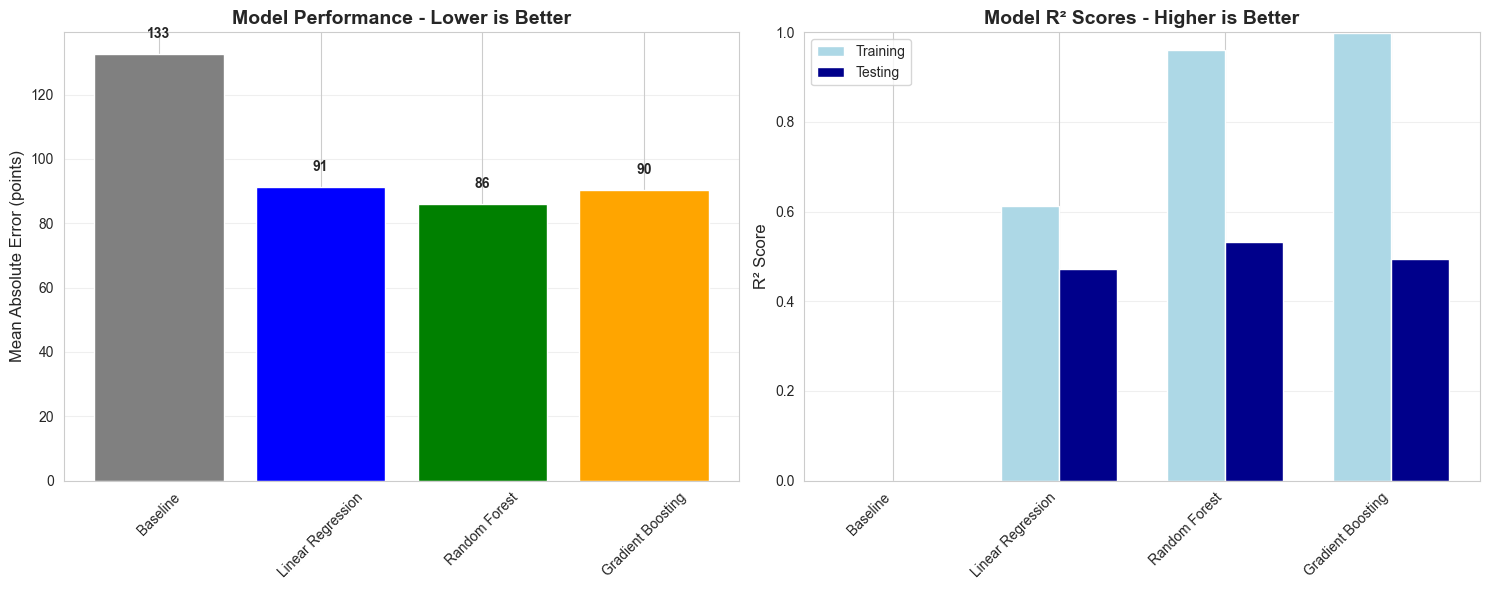

In [10]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# MAE comparison
axes[0].bar(results['Model'], results['MAE'], color=['gray', 'blue', 'green', 'orange'])
axes[0].set_ylabel('Mean Absolute Error (points)', fontsize=12)
axes[0].set_title('Model Performance - Lower is Better', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(results.iterrows()):
    axes[0].text(i, row['MAE'] + 5, f"{row['MAE']:.0f}", ha='center', fontweight='bold')

# R² comparison
x = np.arange(len(results))
width = 0.35
axes[1].bar(x - width/2, results['R² (Train)'], width, label='Training', color='lightblue')
axes[1].bar(x + width/2, results['R² (Test)'], width, label='Testing', color='darkblue')
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('Model R² Scores - Higher is Better', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 9. Feature Importance (Random Forest)


🎯 TOP 20 MOST IMPORTANT FEATURES (Random Forest):

college_career_rate                                         : 0.4536
attendance_rate                                             : 0.2093
graduation_rate                                             : 0.1142
grade9geapplicants1                                         : 0.0398
grade9swdapplicantsperseat1                                 : 0.0298
bbl                                                         : 0.0233
longitude                                                   : 0.0216
census_tract                                                : 0.0191
latitude                                                    : 0.0179
bin                                                         : 0.0164
grade9geapplicantsperseat1                                  : 0.0157
community_board                                             : 0.0150
council_district                                            : 0.0133
zip                                                

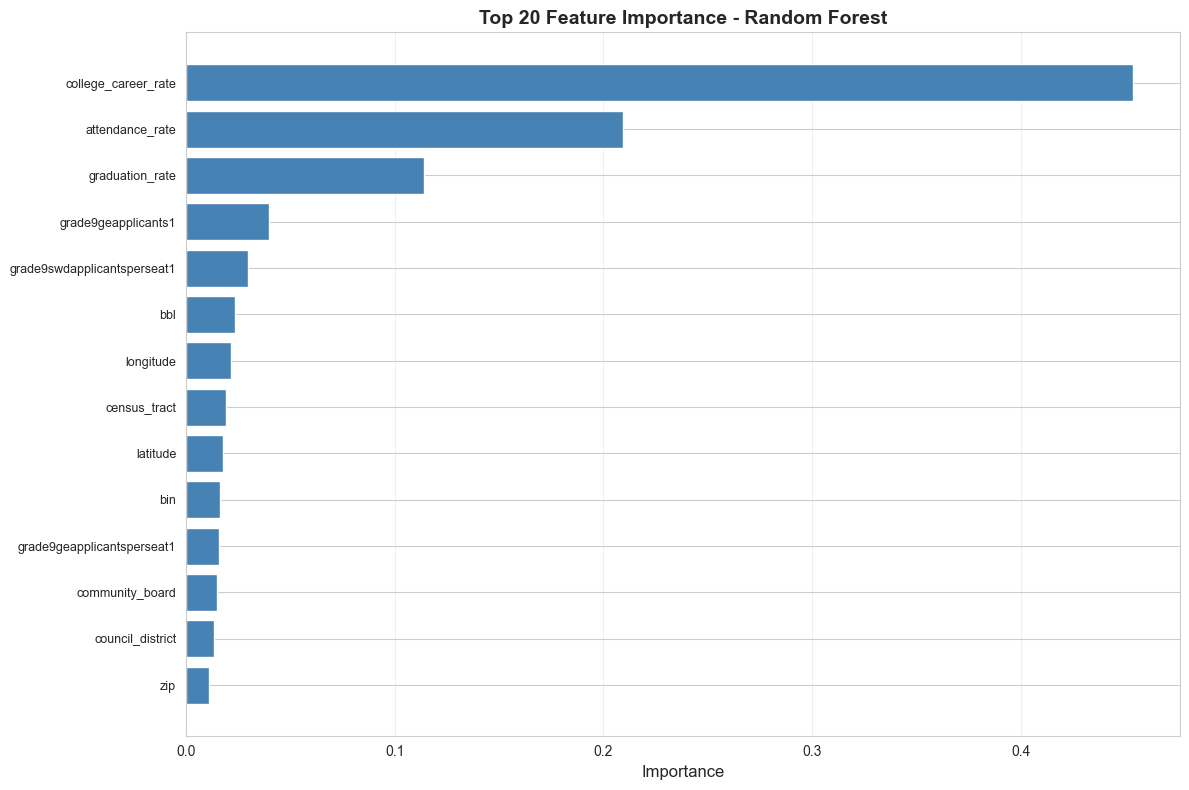

In [11]:
# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n🎯 TOP 20 MOST IMPORTANT FEATURES (Random Forest):\n")
for idx, row in feature_importance.head(20).iterrows():
    print(f"{row['Feature'][:60]:60s}: {row['Importance']:.4f}")

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
top_features = feature_importance.head(20)
ax.barh(range(len(top_features)), top_features['Importance'].values, color='steelblue')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels([feat[:40] for feat in top_features['Feature'].values], fontsize=9)
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 20 Feature Importance - Random Forest', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Prediction vs Actual Visualization

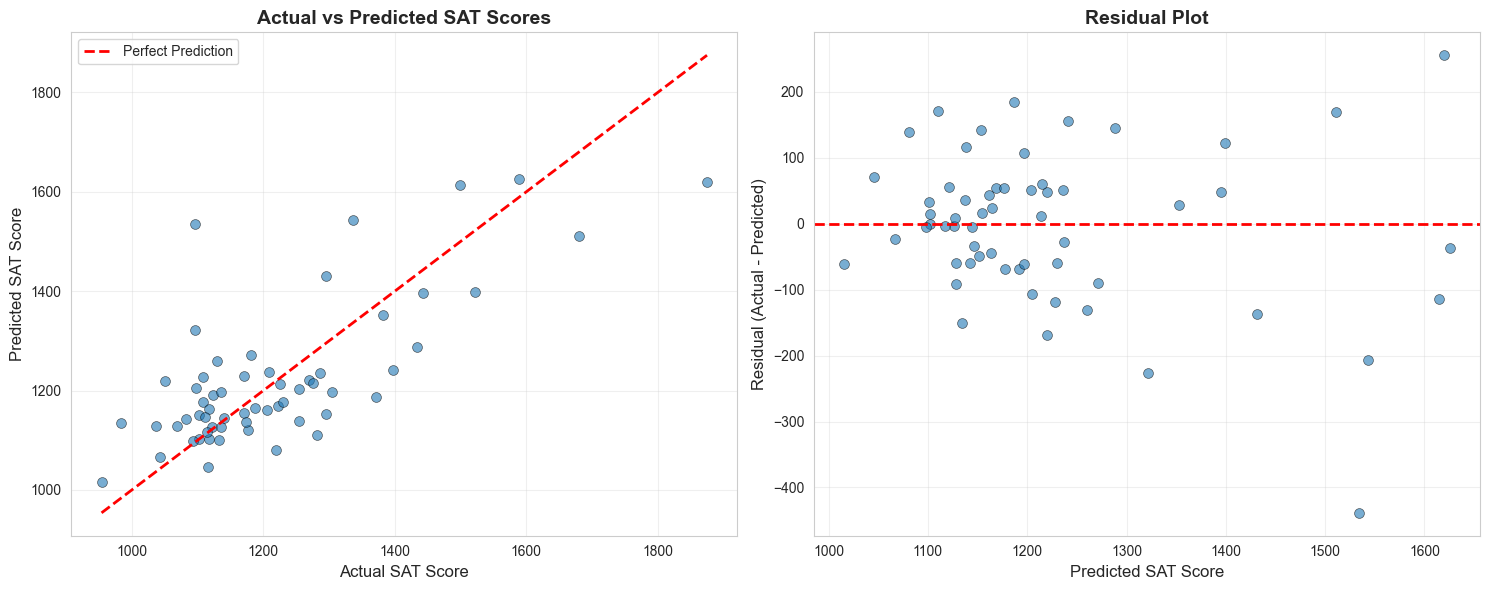


📊 Residual Statistics:
   Mean: -3.90
   Std Dev: 115.93
   Min: -438.46
   Max: 255.58


In [12]:
# Use best model (choose Random Forest for this example)
best_predictions = rf_pred_test

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot: Actual vs Predicted
axes[0].scatter(y_test, best_predictions, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual SAT Score', fontsize=12)
axes[0].set_ylabel('Predicted SAT Score', fontsize=12)
axes[0].set_title('Actual vs Predicted SAT Scores', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residuals plot
residuals = y_test - best_predictions
axes[1].scatter(best_predictions, residuals, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted SAT Score', fontsize=12)
axes[1].set_ylabel('Residual (Actual - Predicted)', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Residual Statistics:")
print(f"   Mean: {residuals.mean():.2f}")
print(f"   Std Dev: {residuals.std():.2f}")
print(f"   Min: {residuals.min():.2f}")
print(f"   Max: {residuals.max():.2f}")

## 11. Identify Over/Under-Performing Schools

In [13]:
# Create dataframe with predictions
test_indices = X_test.index
school_predictions = pd.DataFrame({
    'school_name': ml_data.loc[test_indices, 'school_name_sat'].values if 'school_name_sat' in ml_data.columns else ml_data.loc[test_indices, 'school_name'].values,
    'actual_score': y_test.values,
    'predicted_score': best_predictions,
    'difference': y_test.values - best_predictions
})

# Over-performers (actual much higher than predicted)
print("🌟 TOP 10 OVER-PERFORMING SCHOOLS (Beating Expectations):\n")
over_performers = school_predictions.nlargest(10, 'difference')
for idx, row in over_performers.iterrows():
    print(f"{row['school_name'][:45]:45s}")
    print(f"  Predicted: {row['predicted_score']:.0f}, Actual: {row['actual_score']:.0f} (+{row['difference']:.0f})")
    print()

# Under-performers (actual much lower than predicted)
print("\n📉 TOP 10 UNDER-PERFORMING SCHOOLS (Below Expectations):\n")
under_performers = school_predictions.nsmallest(10, 'difference')
for idx, row in under_performers.iterrows():
    print(f"{row['school_name'][:45]:45s}")
    print(f"  Predicted: {row['predicted_score']:.0f}, Actual: {row['actual_score']:.0f} ({row['difference']:.0f})")
    print()

print("\n💡 Over-performers may have best practices to share!")
print("💡 Under-performers may need additional support.")

🌟 TOP 10 OVER-PERFORMING SCHOOLS (Beating Expectations):

QUEENS HS FOR SCIENCE YORK COL               
  Predicted: 1619, Actual: 1875 (+256)

HOSTOS-LINCOLN ACADEMY SCIENCE               
  Predicted: 1187, Actual: 1372 (+185)

DeWitt Clinton High School                   
  Predicted: 1110, Actual: 1282 (+172)

LEON M GOLDSTEIN HIGH SCHOOL                 
  Predicted: 1511, Actual: 1680 (+169)

BENJAMIN BANNEKER ACADEMY                    
  Predicted: 1241, Actual: 1398 (+157)

Institute for Collaborative Education        
  Predicted: 1289, Actual: 1434 (+145)

MANHATTAN INTERNATIONAL HIGH SCHOOL          
  Predicted: 1153, Actual: 1296 (+143)

Frederick Douglass Academy III Secondary Scho
  Predicted: 1081, Actual: 1219 (+138)

ACADEMY OF AMERICAN STUDIES                  
  Predicted: 1399, Actual: 1522 (+123)

MOTT HALL HIGH SCHOOL                        
  Predicted: 1138, Actual: 1255 (+117)


📉 TOP 10 UNDER-PERFORMING SCHOOLS (Below Expectations):

CENTRAL PARK SECONDARY S

## 12. Save Model and Results

In [14]:
# Save predictions
save_csv(school_predictions, "school_predictions.csv", subfolder="processed", index=False)

# Save feature importance
save_csv(feature_importance, "feature_importance.csv", subfolder="processed", index=False)

# Save model comparison
save_csv(results, "model_comparison.csv", subfolder="processed", index=False)

print("✅ Results saved to data/processed/")
print("   • school_predictions.csv")
print("   • feature_importance.csv")
print("   • model_comparison.csv")

✅ Results saved to data/processed/
   • school_predictions.csv
   • feature_importance.csv
   • model_comparison.csv


## 13. Summary

In [15]:
print("="*70)
print("🤖 PREDICTIVE MODELING - SUMMARY")
print("="*70)

print(f"\n📊 Models Trained: 4")
print(f"   • Baseline (Mean Predictor)")
print(f"   • Linear Regression")
print(f"   • Random Forest")
print(f"   • Gradient Boosting")

print(f"\n🏆 Best Model: {best_model}")
print(f"   R² Score: {results.loc[best_idx, 'R² (Test)']:.3f}")
print(f"   Mean Absolute Error: {results.loc[best_idx, 'MAE']:.0f} points")

print(f"\n🎯 Key Insights:")
print(f"   • Can predict SAT scores with {results.loc[best_idx, 'R² (Test)']*100:.1f}% accuracy")
print(f"   • Average prediction error: ±{results.loc[best_idx, 'MAE']:.0f} points")
print(f"   • Top 3 most important features:")
for idx, row in feature_importance.head(3).iterrows():
    print(f"     {idx+1}. {row['Feature'][:50]}")

print(f"\n💡 Applications:")
print(f"   • Identify schools needing support (under-performers)")
print(f"   • Learn from success stories (over-performers)")
print(f"   • Predict performance for new/changing schools")
print(f"   • Understand what factors drive success")

print("\n" + "="*70)
print("✅ Modeling Complete - Ready for Dashboard!")
print("="*70)

🤖 PREDICTIVE MODELING - SUMMARY

📊 Models Trained: 4
   • Baseline (Mean Predictor)
   • Linear Regression
   • Random Forest
   • Gradient Boosting

🏆 Best Model: Random Forest
   R² Score: 0.532
   Mean Absolute Error: 86 points

🎯 Key Insights:
   • Can predict SAT scores with 53.2% accuracy
   • Average prediction error: ±86 points
   • Top 3 most important features:
     1. college_career_rate
     4. attendance_rate
     3. graduation_rate

💡 Applications:
   • Identify schools needing support (under-performers)
   • Learn from success stories (over-performers)
   • Predict performance for new/changing schools
   • Understand what factors drive success

✅ Modeling Complete - Ready for Dashboard!


## 🎯 Next: Interactive Dashboard

Now we can create an interactive Streamlit dashboard to:
1. Explore the data visually
2. Make predictions for any school
3. Compare schools
4. Visualize feature importance

**Continue to:** Run the dashboard with `streamlit run scripts/education_dashboard.py`